# HER2 status classifier

- Ask what to do with samples with two the same ICGC_IDs
- Ask about ERBB2 minus ploidy 

In [1]:
%load_ext autoreload
%autoreload 2

from utils.cv_helpers import best_params_cv, show_cv_results

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from plotnine import *
from yellowbrick.model_selection import learning_curve, validation_curve

from sklearn.manifold import MDS
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, cohen_kappa_score, f1_score, plot_confusion_matrix

SEED = 0
CV_SCHEME = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=SEED)
PLOT_SIZE = (1000, 800)

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)

- add st. dev to summary table
- add DecisionTree

In [2]:
her2_status_path = '../../data/external/HER2status_Sanger.txt'
her2_to_icgc_path = '../../data/external/sanger_IDs.csv'

In [3]:
her2_to_icgc = pd.read_csv(her2_to_icgc_path)
her2_to_icgc.columns = ['Sample_ID', 'ICGC_ID']
her2_to_icgc.shape

(566, 2)

In [4]:
her2_status = pd.read_csv(her2_status_path, sep='\t')
her2_status['ploidy(n)'] = her2_status['ploidy(n)'].str.replace(',', '.').astype(float)
her2_status.columns = ['Sample_ID', 'HER2_status', 'CN_ERBB2', 'CN_CEP17', 'Ploidy']
her2_status.shape

(555, 5)

In [5]:
her2_status = pd.merge(her2_status, her2_to_icgc, on='Sample_ID', how='left')

There are two samples, which have different sample ID for Sanger and the same sample ID for ICGC. For now i removed first sample. 

In [6]:
her2_status.ICGC_ID.value_counts()
her2_status[her2_status['ICGC_ID'] == 'DO225152']

,Sample_ID,HER2_status,CN_ERBB2,CN_CEP17,Ploidy,ICGC_ID
48,PD11395a_2,0,3,3,2.72,DO225152
52,PD11399a,0,2,2,2.14,DO225152


In [7]:
her2_status = her2_status[her2_status['Sample_ID'] != 'PD11395a_2']
her2_status = her2_status.drop(['Sample_ID'], axis=1)
her2_status = her2_status.set_index('ICGC_ID')
her2_status['HER2_status'] = her2_status['HER2_status'].apply(str)
her2_status.head()

,HER2_status,CN_ERBB2,CN_CEP17,Ploidy
ICGC_ID,,,,
DO225103,0,3,5,3.31
DO225104,0,3,3,3.35
DO225105,0,2,2,2.07
DO225106,0,1,1,1.75
DO225107,0,2,1,3.38


## Create features specified: 
- ERBB2_CN
- ERBB2_CN-ploidy
- ERBB2_CN/CEP17_CN ratio

In [8]:
her2_status['ERBB2_minus_ploidy'] = her2_status['CN_ERBB2'] - her2_status['Ploidy']
her2_status['ERBB2_CEP17_ratio'] = her2_status['CN_ERBB2'] / her2_status['CN_CEP17']
her2_status.head()

,HER2_status,CN_ERBB2,CN_CEP17,Ploidy,ERBB2_minus_ploidy,ERBB2_CEP17_ratio
ICGC_ID,,,,,,
DO225103,0,3,5,3.31,-0.31,0.6
DO225104,0,3,3,3.35,-0.35,1.0
DO225105,0,2,2,2.07,-0.07,1.0
DO225106,0,1,1,1.75,-0.75,1.0
DO225107,0,2,1,3.38,-1.38,2.0


In [9]:
her2_status[her2_status['ERBB2_CEP17_ratio'] == np.inf]

,HER2_status,CN_ERBB2,CN_CEP17,Ploidy,ERBB2_minus_ploidy,ERBB2_CEP17_ratio
ICGC_ID,,,,,,
DO225189,1,19,0,2.00,17.00,inf
DO225270,0,2,0,3.22,-1.22,inf
DO225288,1,23,0,3.40,19.60,inf
DO1014,1,16,0,1.91,14.09,inf


In [10]:
her2_status = her2_status[her2_status['ERBB2_CEP17_ratio'] != np.inf]

## Variance

In [11]:
her2_status_ready_to_analysis = her2_status[['HER2_status', 'CN_ERBB2', 'ERBB2_minus_ploidy', 'ERBB2_CEP17_ratio']]
st_dev = her2_status_ready_to_analysis.describe().loc[['std'], :].T
st_dev

,std
CN_ERBB2,12.197160
ERBB2_minus_ploidy,12.071572
ERBB2_CEP17_ratio,6.023042


## Dataset to analysis

In [12]:
her2_status_ready_to_analysis

,HER2_status,CN_ERBB2,ERBB2_minus_ploidy,ERBB2_CEP17_ratio
ICGC_ID,,,,
DO225103,0,3,-0.31,0.6
DO225104,0,3,-0.35,1.0
DO225105,0,2,-0.07,1.0
DO225106,0,1,-0.75,1.0
DO225107,0,2,-1.38,2.0
...,...,...,...,...
DO225098,0,2,-0.01,1.0
DO225099,0,3,-0.65,1.0
DO225100,0,2,0.00,1.0


/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 24'. Pick better value with 'binwidth'.


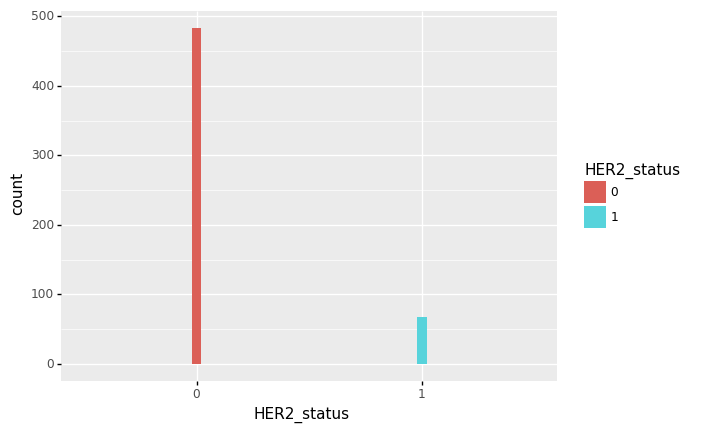

<ggplot: (8736798413279)>

In [13]:
(ggplot(her2_status_ready_to_analysis, aes(x='HER2_status', fill='HER2_status')) + geom_histogram())

## Correlation

In [14]:
her2_status_ready_to_analysis.drop(['HER2_status'], axis=1).corr().abs()

,CN_ERBB2,ERBB2_minus_ploidy,ERBB2_CEP17_ratio
CN_ERBB2,1.000000,0.997593,0.826749
ERBB2_minus_ploidy,0.997593,1.000000,0.833743
ERBB2_CEP17_ratio,0.826749,0.833743,1.000000


<AxesSubplot:>

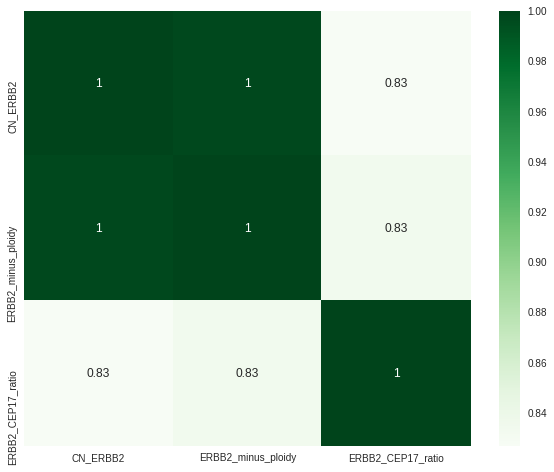

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(her2_status_ready_to_analysis.drop(['HER2_status'], axis=1).corr().abs(), cmap='Greens', annot=True)

## Playground

In [16]:
X = her2_status_ready_to_analysis.drop(['HER2_status'], axis=1)
y = her2_status_ready_to_analysis['HER2_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

In [17]:
minmax_scaler = MinMaxScaler()
scaled_data = minmax_scaler.fit_transform(X)

mds = MDS(n_components=2)
mds_scaled = pd.DataFrame(mds.fit_transform(scaled_data))

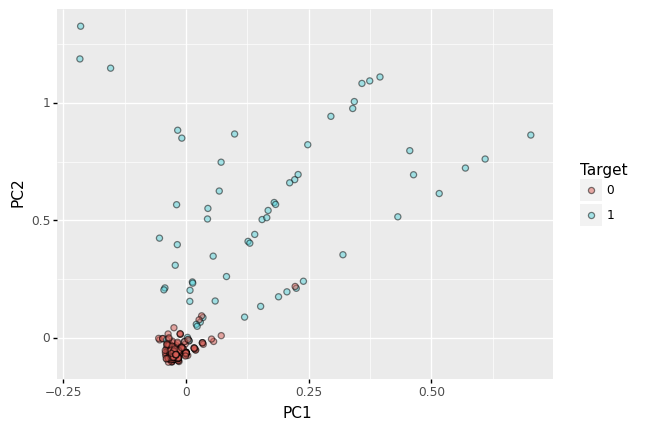

<ggplot: (8736798425067)>

In [18]:
mds_scaled['Target'] = y.tolist()
mds_scaled.columns = ['PC1', 'PC2', 'Target']

(ggplot(mds_scaled, aes(x='PC1', y='PC2', fill='Target')) 
 + geom_point(size=2, alpha=0.5))

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


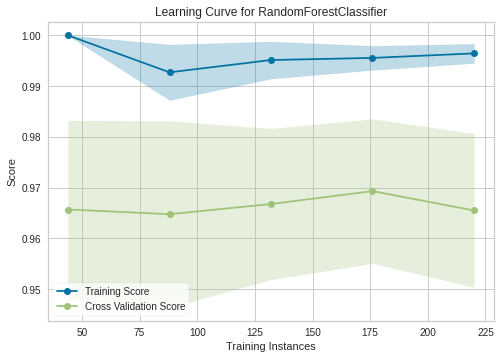

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


LearningCurve(ax=<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>,
              cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
              model=None, n_jobs=-1,
              train_sizes=array([0.1, 0.2, 0.3, 0.4, 0.5]))

In [19]:
learning_curve(RandomForestClassifier(), X, y, cv=CV_SCHEME, train_sizes=np.arange(0.1, 0.6, 0.1), n_jobs=-1)

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


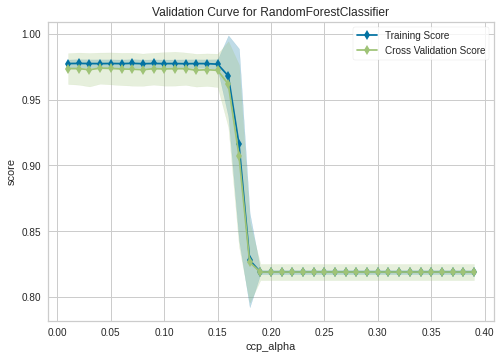

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='ccp_alpha', ylabel='score'>,
                cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
                model=None, n_jobs=-1, param_name='ccp_alpha',
                param_range=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39]),
                scoring='f1_weighted')

In [20]:
validation_curve(RandomForestClassifier(), X, y, scoring='f1_weighted', param_name='ccp_alpha', param_range=np.arange(0.01, 0.4, 0.01), cv=CV_SCHEME, n_jobs=-1)

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


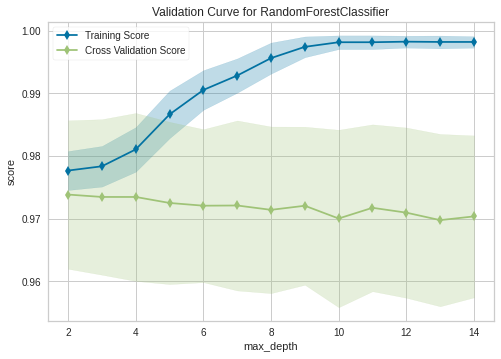

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>,
                cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
                model=None, n_jobs=-1, param_name='max_depth',
                param_range=array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                scoring='f1_weighted')

In [21]:
validation_curve(RandomForestClassifier(), X, y, scoring='f1_weighted', param_name='max_depth', param_range=np.arange(2, 15, 1), cv=CV_SCHEME, n_jobs=-1)

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


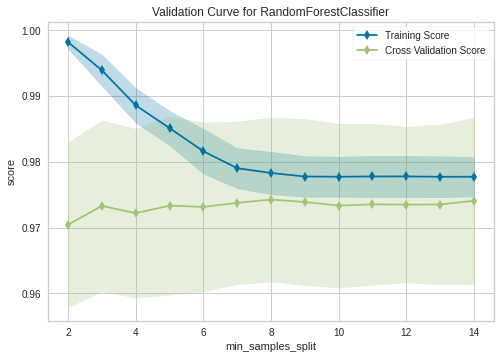

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='min_samples_split', ylabel='score'>,
                cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
                model=None, n_jobs=-1, param_name='min_samples_split',
                param_range=array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                scoring='f1_weighted')

In [22]:
validation_curve(RandomForestClassifier(), X, y, scoring='f1_weighted', param_name='min_samples_split', param_range=np.arange(2, 15, 1), cv=CV_SCHEME, n_jobs=-1)

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


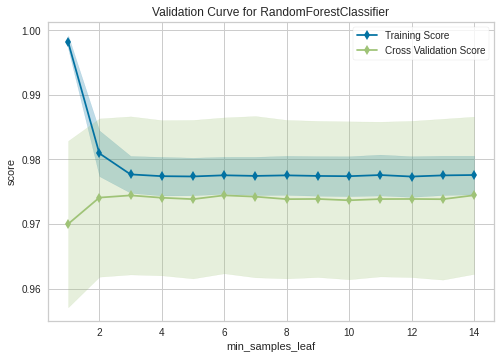

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='min_samples_leaf', ylabel='score'>,
                cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
                model=None, n_jobs=-1, param_name='min_samples_leaf',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                scoring='f1_weighted')

In [23]:
validation_curve(RandomForestClassifier(), X, y, scoring='f1_weighted', param_name='min_samples_leaf', param_range=np.arange(1, 15, 1), cv=CV_SCHEME, n_jobs=-1)

## Simple RandomForest

In [24]:
pipe = Pipeline([
    ('scaler', None),
    ('classifier', None)
])

scoring = {
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score, average='micro'),
    'Recall': make_scorer(recall_score, average='micro'),
    'Kappa': make_scorer(cohen_kappa_score),
    'F1 Weighted': make_scorer(f1_score, average='weighted'),
    'F1 Macro': make_scorer(f1_score, average='macro')
}

hyperparameters_space = {
    'classifier': [RandomForestClassifier()],
}

grid_search_rf_no_tuning = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparameters_space,
    scoring=scoring,
    n_jobs=-1,
    cv=CV_SCHEME,
    refit='Accuracy',
    verbose=2,
    return_train_score=True
)

In [25]:
grid_search_rf_no_tuning.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('scaler', None), ('classifier', None)]),
             n_jobs=-1, param_grid={'classifier': [RandomForestClassifier()]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': 'accuracy',
                      'F1 Macro': make_scorer(f1_score, average=macro),
                      'F1 Weighted': make_scorer(f1_score, average=weighted),
                      'Kappa': make_scorer(cohen_kappa_score),
                      'Precision': make_scorer(precision_score, average=micro),
                      'Recall': make_scorer(recall_score, average=micro)},
             verbose=2)

In [26]:
print(grid_search_rf_no_tuning.score(X_test, y_test))
cv_results = grid_search_rf_no_tuning.cv_results_

show_cv_results(cv_results)

0.9710144927536232


Mean  SD
Train Accuracy     0.999939   0
      Precision    0.999939   0
      Recall       0.999939   0
      F1 Macro     0.999859   0
      F1 Weighted  0.999939   0
      Kappa        0.999719   0
Test  Accuracy     0.967323   0
      Precision    0.967323   0
      Recall       0.967323   0
      F1 Macro     0.921204   0
      F1 Weighted  0.966597   0
      Kappa        0.842599   0

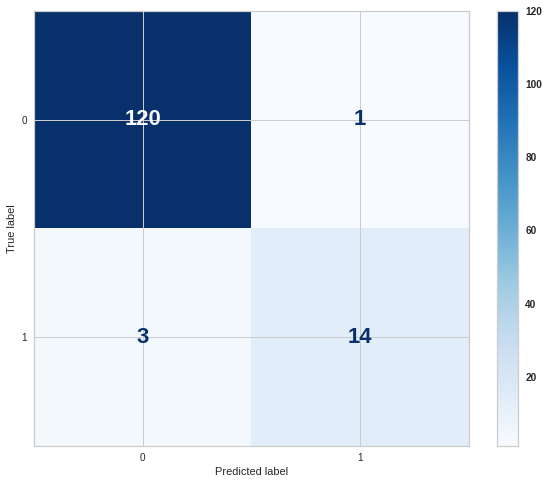

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
font = {'weight' : 'bold', 'size'   : 22}
matplotlib.rc('font', **font)
plot_confusion_matrix(grid_search_rf_no_tuning.best_estimator_, X_test, y_test, ax=ax, cmap=plt.cm.Blues)

## RandomForest with hyperparameters tuning

In [28]:
pipe = Pipeline([
    ('scaler', None),
    ('classifier', None)
])

scoring = {
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score, average='micro'),
    'Recall': make_scorer(recall_score, average='micro'),
    'F1 Weighted': make_scorer(f1_score, average='weighted'),
    'F1 Macro': make_scorer(f1_score, average='macro'),
    'Kappa': make_scorer(cohen_kappa_score)
}

hyperparameters_space = {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [200],
    'classifier__ccp_alpha': [0.01, 0.02, 0.04, 0.08, 0.2],
    'classifier__max_depth': [1, 2, 4, 8],
    'classifier__min_samples_split': [2, 4, 8],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced']
}

grid_search_rf_tuning = GridSearchCV(
    estimator=pipe,
    scoring=scoring,
    param_grid=hyperparameters_space,
    cv=CV_SCHEME,
    refit='Accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

In [29]:
grid_search_rf_tuning.fit(X_train, y_train)

Fitting 50 folds for each of 1920 candidates, totalling 96000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 1921 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 2528 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 3217 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4837 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5768 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6781 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7874 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 9049 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 10304 tasks      

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('scaler', None), ('classifier', None)]),
             n_jobs=-1,
             param_grid={'classifier': [RandomForestClassifier(bootstrap=False,
                                                               ccp_alpha=0.01,
                                                               max_depth=1,
                                                               n_estimators=200)],
                         'classifier__bootstrap': [True, False],
                         'classifier__ccp_alpha': [0.01, 0.02, 0.04, 0.08, 0.2...
                         'classifier__n_estimators': [200]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': 'accuracy',
                      'F1 Macro': make_scorer(f1_score, average=macro),
                      'F1 Weighted': make_scorer(f1_score, average=weighted),
                      'Kappa': mak

In [30]:
print(grid_search_rf_tuning.score(X_test, y_test))
print(grid_search_rf_tuning.best_params_['classifier'])
cv_results_df = pd.DataFrame(pd.DataFrame(grid_search_rf_tuning.cv_results_))
show_cv_results(cv_results_df)

0.9710144927536232
RandomForestClassifier(bootstrap=False, ccp_alpha=0.01, max_depth=1,
                       n_estimators=200)


Mean        SD
Train Accuracy     0.969105  0.021665
      Precision    0.969105  0.021665
      Recall       0.969105  0.021665
      F1 Macro     0.917511  0.103615
      F1 Weighted  0.966486  0.034084
      Kappa        0.838378  0.192934
Test  Accuracy     0.963694  0.020935
      Precision    0.963694  0.020935
      Recall       0.963694  0.020935
      F1 Macro     0.904427  0.100897
      F1 Weighted  0.960945  0.033042
      Kappa        0.812389  0.187575

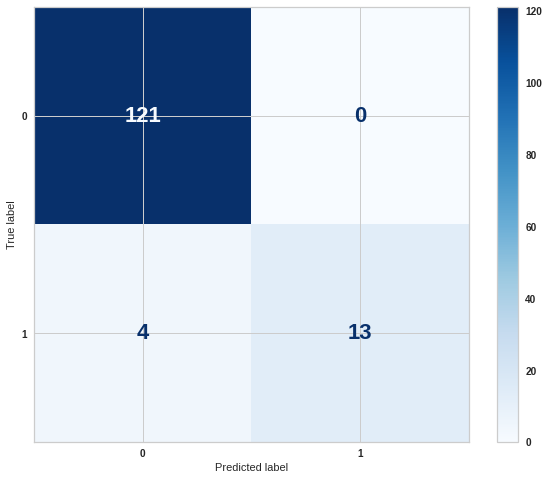

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
font = {'weight' : 'bold', 'size'   : 22}
matplotlib.rc('font', **font)
plot_confusion_matrix(grid_search_rf_tuning.best_estimator_, X_test, y_test, ax=ax, cmap=plt.cm.Blues)

# DecisionTree 

In [32]:
pipe = Pipeline([
    ('scaler', None),
    ('classifier', None)
])

scoring = {
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score, average='micro'),
    'Recall': make_scorer(recall_score, average='micro'),
    'F1 Weighted': make_scorer(f1_score, average='weighted'),
    'F1 Macro': make_scorer(f1_score, average='macro'),
    'Kappa': make_scorer(cohen_kappa_score)
}

hyperparameters_space = {
    'classifier': [DecisionTreeClassifier()],
    'scaler': [MinMaxScaler()],
    'classifier__ccp_alpha': [0.01, 0.02, 0.04, 0.08, 0.2],
    'classifier__max_depth': [1, 2, 4, 8],
    'classifier__min_samples_split': [2, 4, 8],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced']
}

grid_search_dt_tuning = GridSearchCV(
    estimator=pipe,
    scoring=scoring,
    param_grid=hyperparameters_space,
    cv=CV_SCHEME,
    refit='Accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)


In [33]:
grid_search_dt_tuning.fit(X_train, y_train)

Fitting 50 folds for each of 960 candidates, totalling 48000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 3476 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 5256 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 7364 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 12548 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 15624 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 19028 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 22752 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 26804 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 31176 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 35876 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 40896 ta

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('scaler', None), ('classifier', None)]),
             n_jobs=-1,
             param_grid={'classifier': [DecisionTreeClassifier(ccp_alpha=0.01,
                                                               max_depth=1,
                                                               min_samples_leaf=2)],
                         'classifier__ccp_alpha': [0.01, 0.02, 0.04, 0.08, 0.2],
                         'classifier__class_weight': [None, 'balanced'],
                         'cla...
                         'scaler': [MinMaxScaler()]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': 'accuracy',
                      'F1 Macro': make_scorer(f1_score, average=macro),
                      'F1 Weighted': make_scorer(f1_score, average=weighted),
                      'Kappa': make_scorer(cohen_kappa_score),
                

In [34]:
print(grid_search_dt_tuning.score(X_test, y_test))
print(grid_search_dt_tuning.best_params_['classifier'])
cv_results_df = pd.DataFrame(pd.DataFrame(grid_search_dt_tuning.cv_results_))
show_cv_results(cv_results_df)

0.9710144927536232
DecisionTreeClassifier(ccp_alpha=0.01, max_depth=1, min_samples_leaf=2)


Mean        SD
Train Accuracy     0.962408  0.022524
      Precision    0.962408  0.022524
      Recall       0.962408  0.022524
      F1 Macro     0.905613  0.102471
      F1 Weighted  0.960536  0.033922
      Kappa        0.814787  0.190876
Test  Accuracy     0.955320  0.022268
      Precision    0.955320  0.022268
      Recall       0.955320  0.022268
      F1 Macro     0.889816  0.099652
      F1 Weighted  0.953578  0.032976
      Kappa        0.783437  0.185384

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


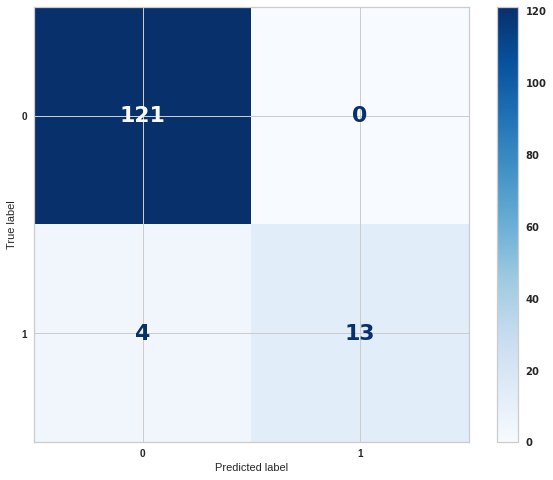

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 22}
matplotlib.rc('font', **font)
plot_confusion_matrix(grid_search_dt_tuning.best_estimator_, X_test, y_test, ax=ax, cmap=plt.cm.Blues)

[Text(223.2, 224.235, 'CN_ERBB2 <= 6.5\ngini = 0.216\nsamples = 138\nvalue = [121, 17]'),
 Text(111.6, 74.745, 'gini = 0.032\nsamples = 122\nvalue = [120, 2]'),
 Text(334.79999999999995, 74.745, 'gini = 0.117\nsamples = 16\nvalue = [1, 15]')]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


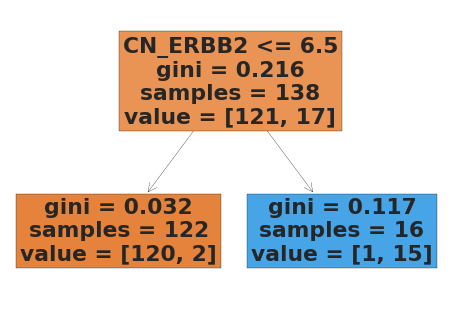

In [36]:
plot_tree(grid_search_dt_tuning.best_params_['classifier'].fit(X_test, y_test), feature_names=X.columns, filled=True)

# On full data

In [37]:
full_data_path = '../data/external/HER2status_MNM.csv'
full_data = pd.read_csv(full_data_path, sep=';')

full_data['ploidy(n)'] = full_data['ploidy(n)'].str.replace(',', '.').astype(float)
full_data.columns = ['Sample_ID', 'HER2_status', 'CN_ERBB2', 'CN_CEP17', 'Ploidy']
full_data = full_data.set_index('Sample_ID')
full_data.shape

(1206, 4)

In [38]:
full_data['ERBB2_minus_ploidy'] = full_data['CN_ERBB2'] - full_data['Ploidy']
full_data['ERBB2_CEP17_ratio'] = full_data['CN_ERBB2'] / full_data['CN_CEP17']
full_data['HER2_status'] = full_data['HER2_status'].apply(str)
full_data.head()

,HER2_status,CN_ERBB2,CN_CEP17,Ploidy,ERBB2_minus_ploidy,ERBB2_CEP17_ratio
Sample_ID,,,,,,
CPCT02010003,0,2,2,2.0,0.0,1.00
CPCT02010260,1,29,4,3.0,26.0,7.25
CPCT02010267TII,1,5,2,4.0,1.0,2.50
CPCT02010276TII,0,2,2,2.0,0.0,1.00
CPCT02010281,0,5,5,4.0,1.0,1.00


In [39]:
full_data[full_data['ERBB2_CEP17_ratio'] == np.inf]

,HER2_status,CN_ERBB2,CN_CEP17,Ploidy,ERBB2_minus_ploidy,ERBB2_CEP17_ratio
Sample_ID,,,,,,
CPCT02040013,0,1,0,2.00,-1.00,inf
CPCT02080006,0,2,0,2.00,0.00,inf
CPCT02300018,0,1,0,2.00,-1.00,inf
DO218168,0,2,0,2.00,0.00,inf
PD13166a,1,19,0,2.00,17.00,inf
PD14471a_2,0,2,0,3.22,-1.22,inf
PD18050a,1,23,0,3.40,19.60,inf


In [40]:
full_data = full_data[full_data['ERBB2_CEP17_ratio'] != np.inf]

In [41]:
full_data

,HER2_status,CN_ERBB2,CN_CEP17,Ploidy,ERBB2_minus_ploidy,ERBB2_CEP17_ratio
Sample_ID,,,,,,
CPCT02010003,0,2,2,2.00,0.00,1.00
CPCT02010260,1,29,4,3.00,26.00,7.25
CPCT02010267TII,1,5,2,4.00,1.00,2.50
CPCT02010276TII,0,2,2,2.00,0.00,1.00
CPCT02010281,0,5,5,4.00,1.00,1.00
...,...,...,...,...,...,...
PD9842a,0,2,2,2.01,-0.01,1.00
PD9843a,0,3,3,3.65,-0.65,1.00
PD9844a,0,2,2,2.00,0.00,1.00


/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 35'. Pick better value with 'binwidth'.


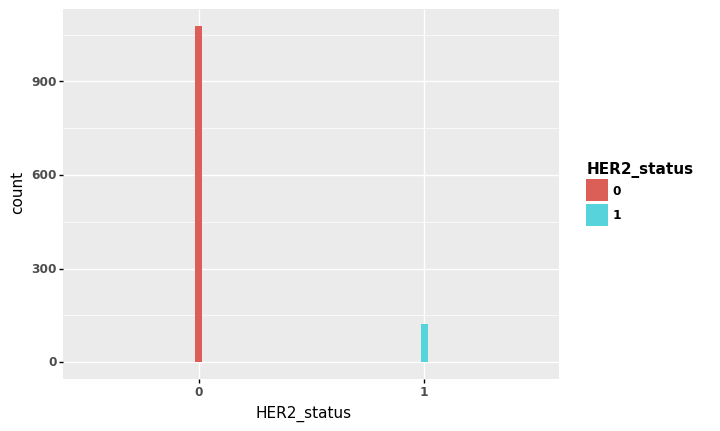

<ggplot: (8737101807174)>

In [42]:
(ggplot(full_data, aes(x='HER2_status', fill='HER2_status')) + geom_histogram())

In [43]:
X = full_data.drop(['HER2_status'], axis=1)
y = full_data[['HER2_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

In [44]:
pipe = Pipeline([
    ('scaler', None),
    ('classifier', None)
])

scoring = {
    'Accuracy': 'accuracy',
    'Precision': make_scorer(precision_score, average='micro'),
    'Recall': make_scorer(recall_score, average='micro'),
    'F1 Weighted': make_scorer(f1_score, average='weighted'),
    'F1 Macro': make_scorer(f1_score, average='macro'),
    'Kappa': make_scorer(cohen_kappa_score)
}

hyperparameters_space = {
    'classifier': [DecisionTreeClassifier()],
    'scaler': [MinMaxScaler()],
    'classifier__ccp_alpha': [0.01, 0.02, 0.04, 0.08, 0.2],
    'classifier__max_depth': [1, 2, 4, 8],
    'classifier__min_samples_split': [2, 4, 8],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': [None, 'balanced']
}

grid_search_dt_tuning = GridSearchCV(
    estimator=pipe,
    scoring=scoring,
    param_grid=hyperparameters_space,
    cv=CV_SCHEME,
    refit='Accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

grid_search_dt_tuning.fit(X_train, y_train)

Fitting 50 folds for each of 960 candidates, totalling 48000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1834 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2724 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 3778 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 6370 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 7908 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 9610 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 11472 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 13498 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 15684 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 18034 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 20544 tasks

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=Pipeline(steps=[('scaler', None), ('classifier', None)]),
             n_jobs=-1,
             param_grid={'classifier': [DecisionTreeClassifier(ccp_alpha=0.01,
                                                               max_depth=1,
                                                               min_samples_leaf=2)],
                         'classifier__ccp_alpha': [0.01, 0.02, 0.04, 0.08, 0.2],
                         'classifier__class_weight': [None, 'balanced'],
                         'cla...
                         'scaler': [MinMaxScaler()]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': 'accuracy',
                      'F1 Macro': make_scorer(f1_score, average=macro),
                      'F1 Weighted': make_scorer(f1_score, average=weighted),
                      'Kappa': make_scorer(cohen_kappa_score),
                

In [45]:
print(grid_search_dt_tuning.score(X_test, y_test))
print(grid_search_dt_tuning.best_params_['classifier'])
cv_results_df = pd.DataFrame(pd.DataFrame(grid_search_dt_tuning.cv_results_))
show_cv_results(cv_results_df)

0.98
DecisionTreeClassifier(ccp_alpha=0.01, max_depth=1, min_samples_leaf=2)


Mean        SD
Train Accuracy     0.972341  0.017584
      Precision    0.972341  0.017584
      Recall       0.972341  0.017584
      F1 Macro     0.912551  0.101345
      F1 Weighted  0.970119  0.027716
      Kappa        0.827815  0.191134
Test  Accuracy     0.970313  0.017685
      Precision    0.970313  0.017685
      Recall       0.970313  0.017685
      F1 Macro     0.906985  0.100497
      F1 Weighted  0.968085  0.027528
      Kappa        0.816747  0.189492

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


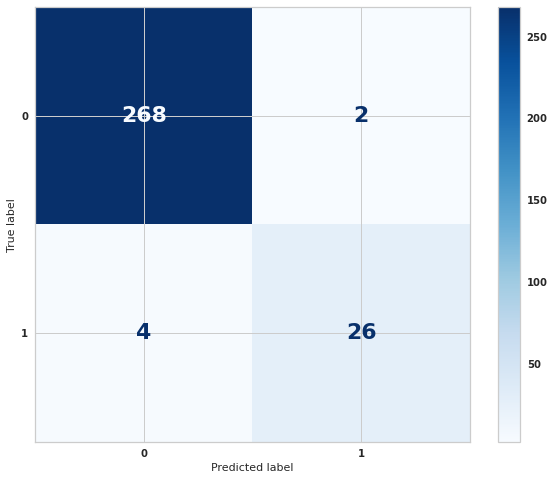

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
font = {'weight' : 'bold', 'size'   : 22}
matplotlib.rc('font', **font)
plot_confusion_matrix(grid_search_dt_tuning.best_estimator_, X_test, y_test, ax=ax, cmap=plt.cm.Blues)

[Text(223.2, 224.235, 'ERBB2_minus_ploidy <= 5.565\ngini = 0.182\nsamples = 899\nvalue = [808, 91]'),
 Text(111.6, 74.745, 'gini = 0.029\nsamples = 815\nvalue = [803, 12]'),
 Text(334.79999999999995, 74.745, 'gini = 0.112\nsamples = 84\nvalue = [5, 79]')]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


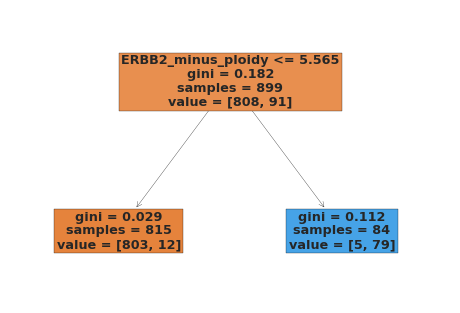

In [47]:
plot_tree(grid_search_dt_tuning.best_params_['classifier'].fit(X_train, y_train), feature_names=X.columns, filled=True)